# Model Training
In this notebook, we will train our VAE model. This involves:

1. Encoder
2. Decoder
3. Full Model

## Importing Packages
We will be using Keras to build and train our VAE

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib notebook
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import h5py

import keras
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Concatenate
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.models import model_from_json

from IPython import display
import numpy as np
import pandas as pd

from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

Using TensorFlow backend.


## Definition of Constants
Hyper parameters and constants will all be located here for ease of adjustments

In [2]:
categorical_dim = 11
categorical_map = {0:0, 0.5:1, 1: 2, 1.5:3, 2:4, 2.5:5, 3:6, 3.5:7, 4:8, 4.5:9, 5:10}
reverse_categorical_map = {0:0, 1:0.5, 2:1, 3:1.5, 4:2, 5:2.5, 6:3, 7:3.5, 8:4, 9:4.5, 10:5}
continuous_dim = 3
binary_dim = 1
original_dim = binary_dim + continuous_dim + categorical_dim
intermediate_dim_1 = 12
intermediate_dim_2 = 8
latent_dim = 4
batch_size = 100
epochs = 50
epsilon_std = 1.0

## Building the Model
We have to write our own custom layer and custom loss function as these are not supported on Keras natively. There are a few things to be done:

1. Custom KLDivergence Layer
2. Custom Loss Functions
3. Building the Model

### KL Divergence Layer
To ensure modularity, we decided to create a separate layer for KL Divergence. This layer will account for the loss required. 

In [3]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

### Custom Loss Functions
As the yelp dataset contains binary, categorical as well as continuous data, we will build 3 custom loss functions.

#### Binary Loss Function

In [4]:
def binary_loss(y_true, y_pred):
	# input dimension is (batchsize, 1)
    return K.binary_crossentropy(y_true, y_pred) # the dimension of return value is (batchsize , 1)

#### Categorical Loss Function

In [5]:
def categorical_loss(y_true, y_pred):
	# input dimension is (batchsize, number of categories)
  return K.categorical_crossentropy(y_true, y_pred) # the dimension of return value is (batchsize , 1)

#### Continuous Loss Function

In [6]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis) # return a tensor of shape (batch_size, 1)

def continuous_loss(y_true, y_pred):
	# need to return log probability for continuous loss.
	# will get a (batchsize, 6 continuous variable input) where 3 of the 6 represents mu and the others logvar
	# y_true will be (batchsize, 3)
  mu, logvar = tf.split(y_pred, num_or_size_splits = 2, axis = 1)
  return -1 * log_normal_pdf(y_true, mu, logvar) 

### Model Architecture
- tanh/sigmoid is used because Relu resulted in loss going to infinity

In [7]:
x = Input(shape=(original_dim,), name='input_x')
h = Dense(intermediate_dim_1, activation='tanh', name='hidden_enc_1')(x)
h = Dense(intermediate_dim_2, activation='tanh', name='hidden_enc_2')(h)

z_mu = Dense(latent_dim, name='z_mu')(h)
z_log_var = Dense(latent_dim, name='z_log_var')(h)

z_mu, z_log_var = KLDivergenceLayer(name='KL_Divergence')([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(name='input_eps',tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

decode_1 = Dense(intermediate_dim_2, activation='tanh', name='hidden_dec_2')
h_dec = decode_1(z)

decode_2 = Dense(intermediate_dim_1, activation='tanh', name='hidden_dec_1')
h_dec = decode_2(h_dec)

x_pred_coordinates_mu_layer = Dense(2, activation='sigmoid',name='x_pred_coordinates_mu')
x_pred_coordinates_mu = x_pred_coordinates_mu_layer(h_dec)

x_pred_coordinates_log_var_layer = Dense(2, name='x_pred_coordinates_log_var')
x_pred_coordinates_log_var = x_pred_coordinates_log_var_layer(h_dec)

x_pred_coordinates_layer = Concatenate(axis=-1, name = 'x_pred_coordinates')
x_pred_coordinates = x_pred_coordinates_layer([x_pred_coordinates_mu, x_pred_coordinates_log_var])

x_pred_review_mu_layer = Dense(1, activation='relu', name='x_pred_review_mu')
x_pred_review_mu = x_pred_review_mu_layer(h_dec)

x_pred_review_log_var_layer = Dense(1, name='x_pred_review_log_var')
x_pred_review_log_var = x_pred_review_log_var_layer(h_dec)

x_pred_review_layer = Concatenate(axis=-1, name = 'x_pred_review')
x_pred_review = x_pred_review_layer([x_pred_review_mu, x_pred_review_log_var])

x_pred_binary_layer = Dense(binary_dim, activation='sigmoid', name='x_pred_binary')
x_pred_binary = x_pred_binary_layer(h_dec) # binary cross entropy

x_pred_categorical_layer = Dense(categorical_dim, activation='softmax', name='x_pred_categorical')
x_pred_categorical = x_pred_categorical_layer(h_dec) # categorical cross entropy

vae = Model(inputs=[x,eps], outputs=[x_pred_binary, x_pred_categorical, x_pred_review, x_pred_coordinates])

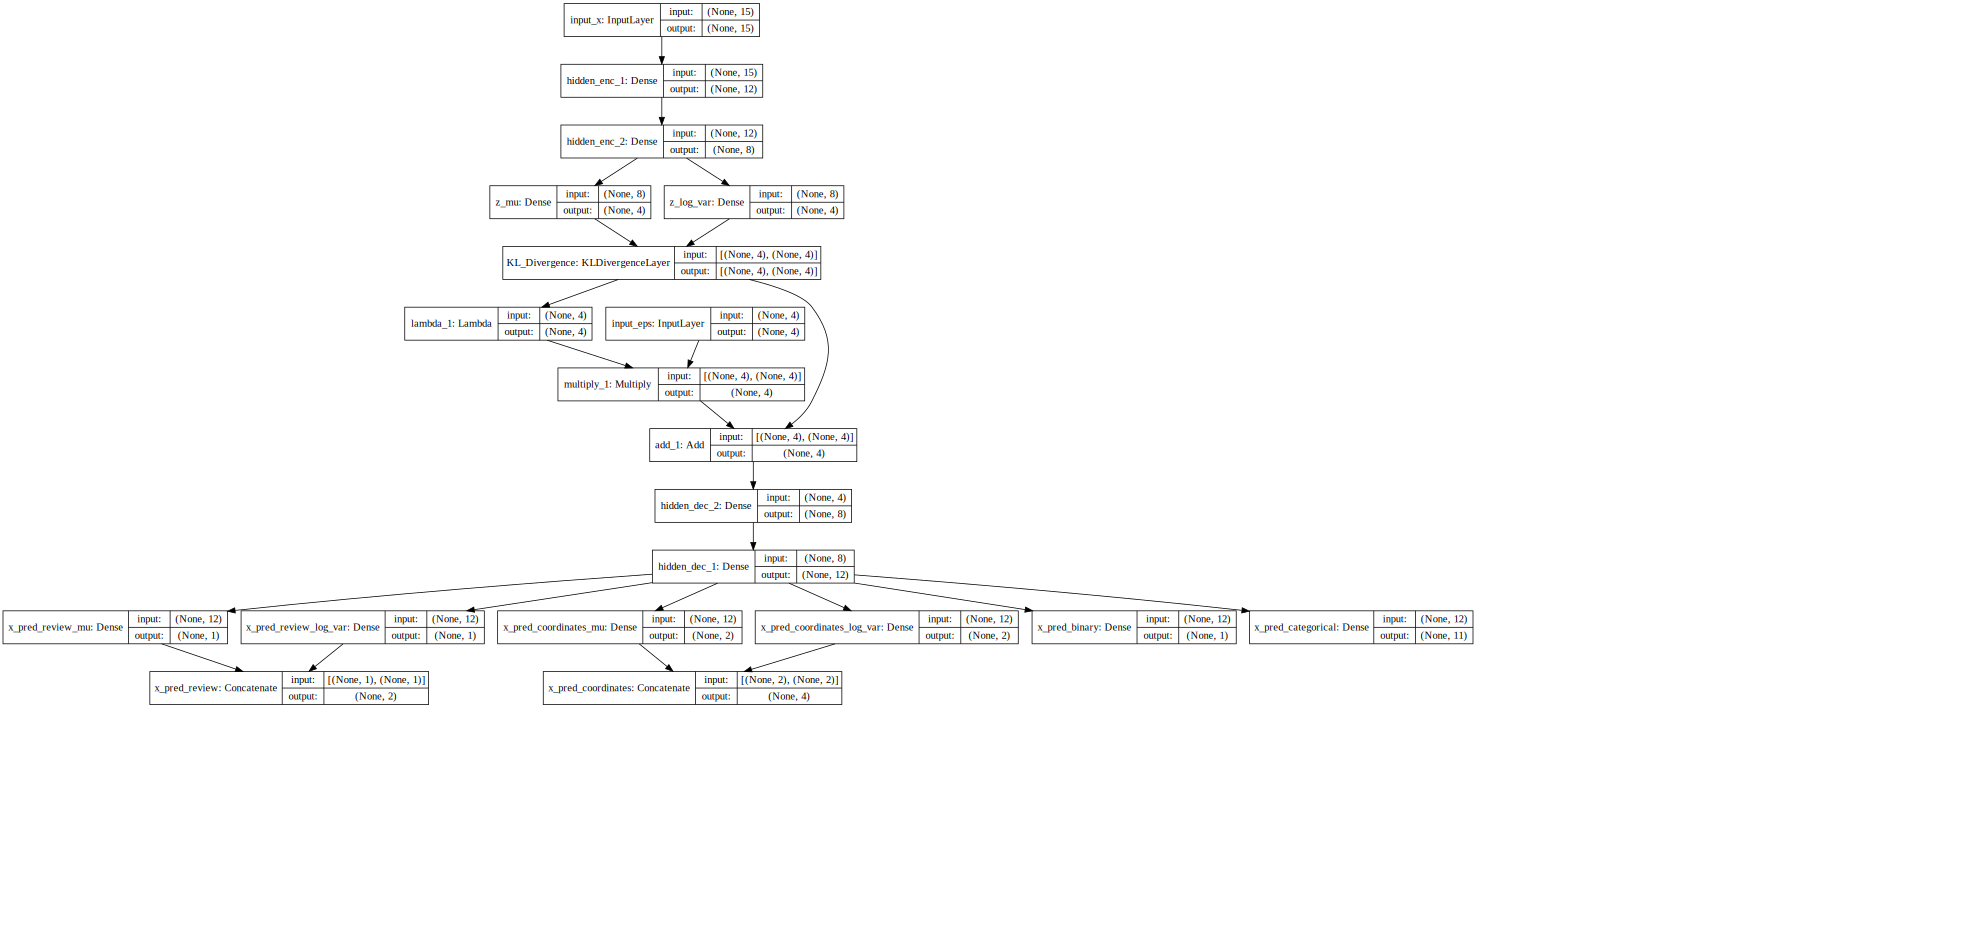

In [8]:
SVG(model_to_dot(vae, show_shapes=True)
    .create(prog='dot', format='svg'))

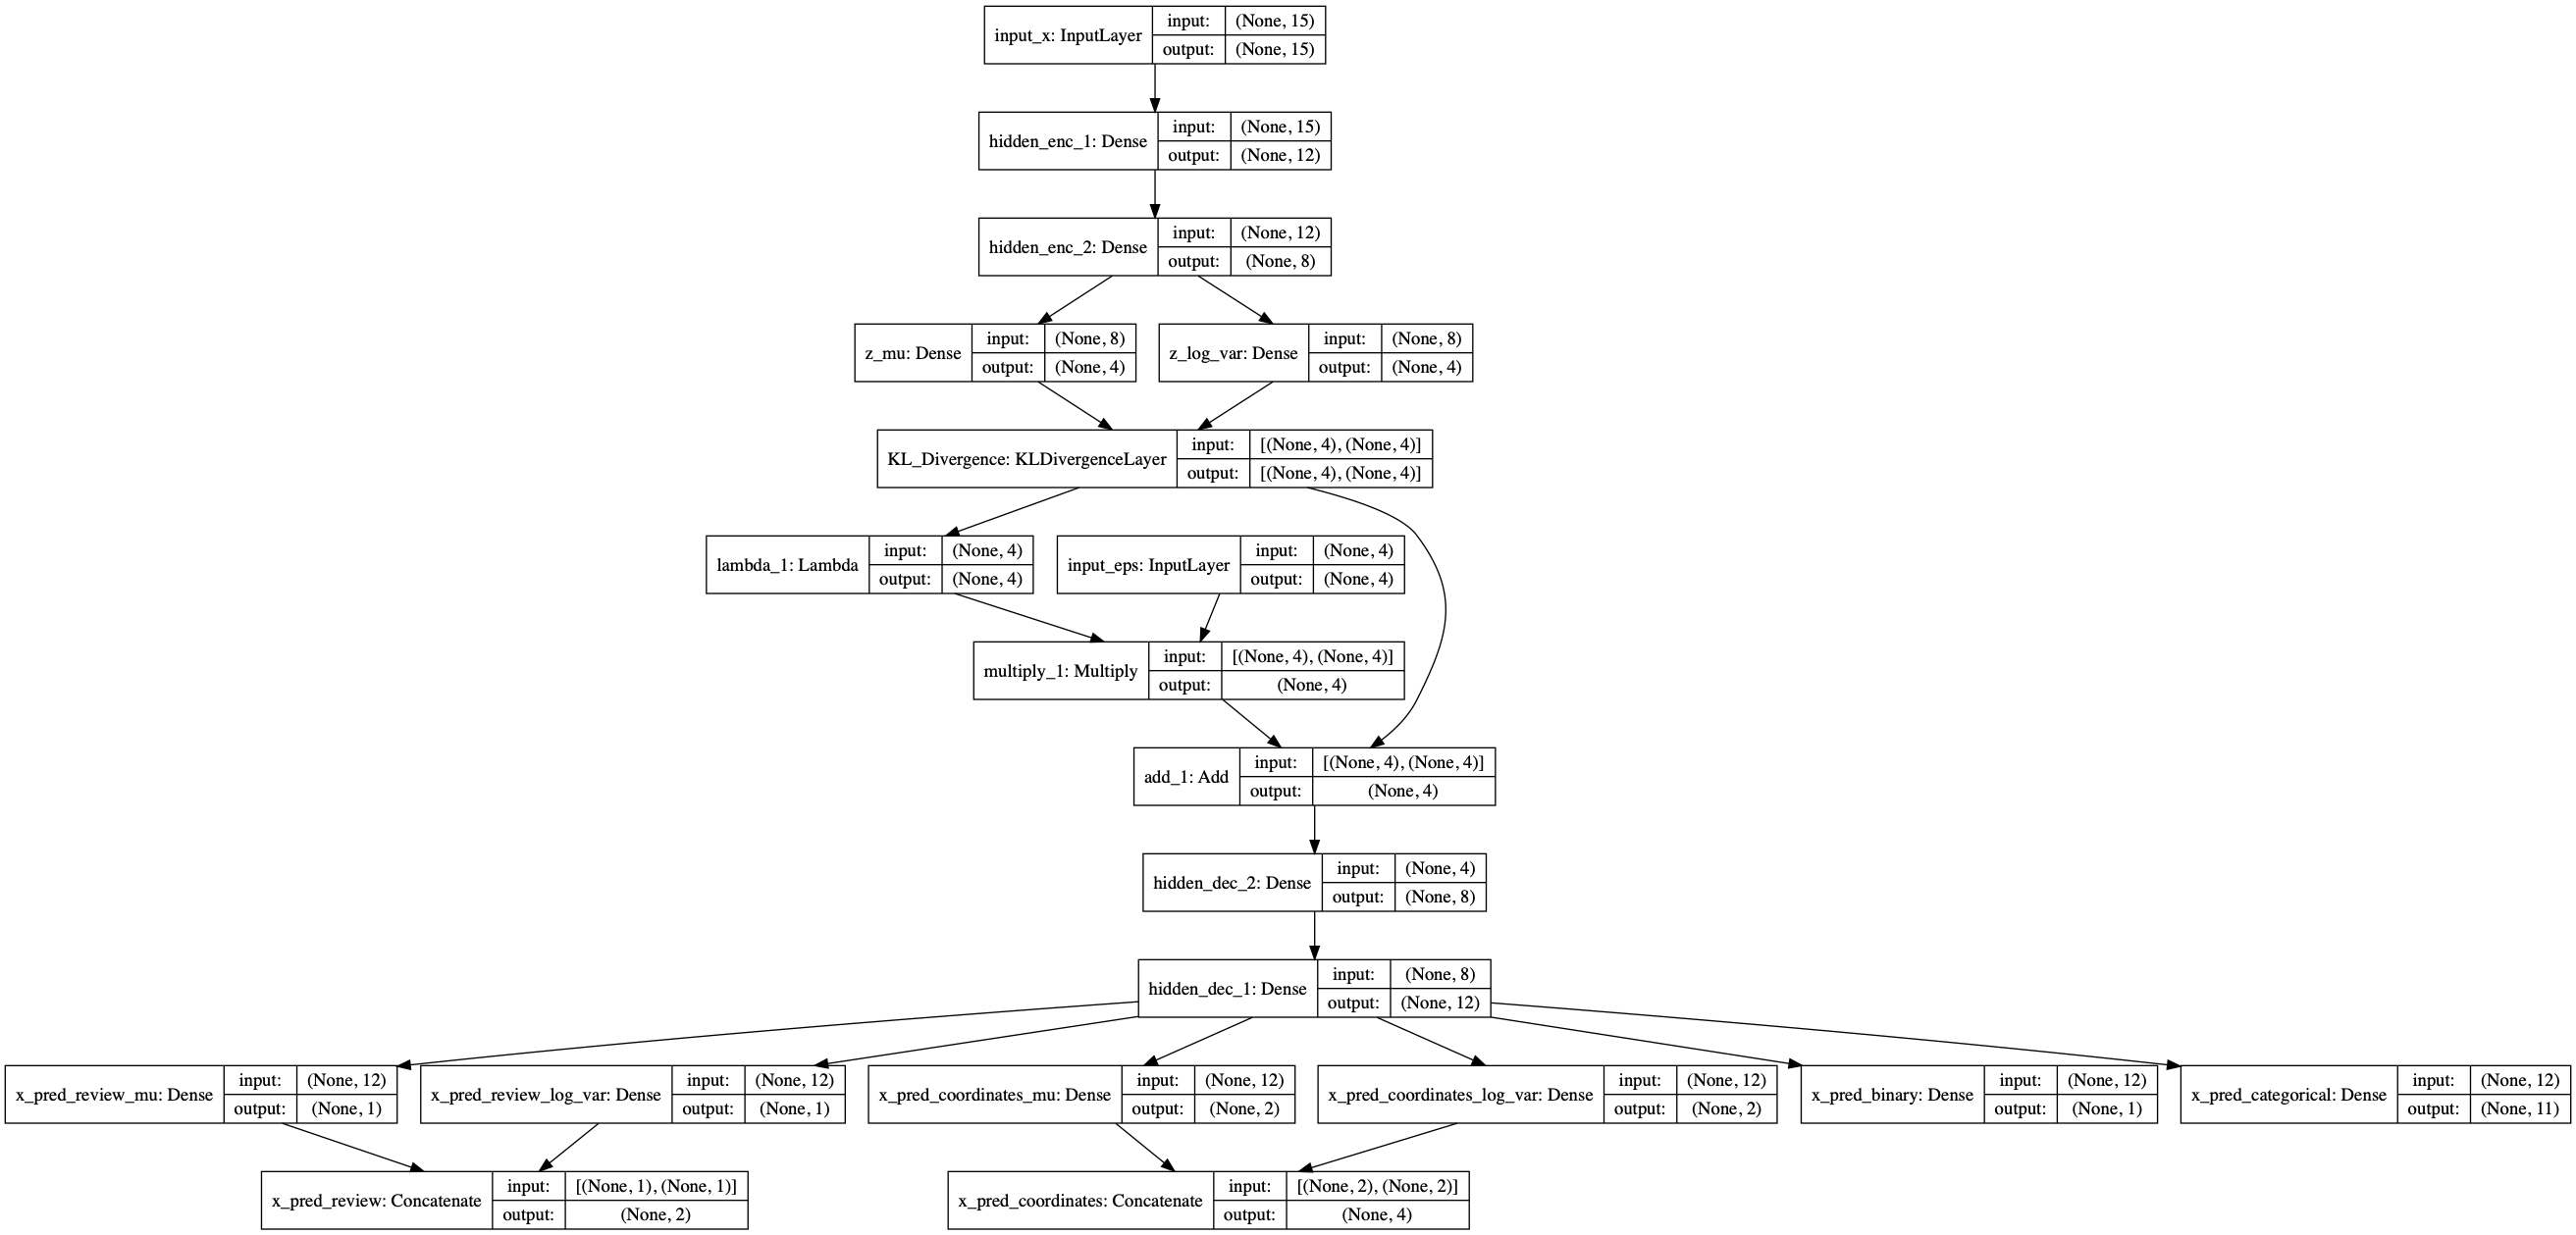

In [9]:
plot_model(
    model=vae, show_shapes=True,
    to_file='./description/vae_full_model.png'
)

### Compiling Model and Setting Parameters

In [10]:
optimizer = keras.optimizers.Adam(lr=0.0001,clipvalue=1)
vae.compile(optimizer=optimizer, loss=[binary_loss, categorical_loss, continuous_loss, continuous_loss], loss_weights=[1, 1, 1, 1])

In [11]:
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
hidden_enc_1 (Dense)            (None, 12)           192         input_x[0][0]                    
__________________________________________________________________________________________________
hidden_enc_2 (Dense)            (None, 8)            104         hidden_enc_1[0][0]               
__________________________________________________________________________________________________
z_mu (Dense)                    (None, 4)            36          hidden_enc_2[0][0]               
____________________________________________________________________________________________

## Data Loading and Preprocessing

In [12]:
dataset = np.genfromtxt('./samples/yelp_business.csv',delimiter=',',skip_header=1)
dataset = dataset[~np.isnan(dataset).any(axis=1)]
test_set, train_set = np.split(dataset,[1], axis = 0)

def format_data(dataset):
  # handling the categorical variables
  coordinates, ratings, reviews, is_opens = np.split(dataset, [2, 3, 4], axis = 1)
  one_hot_array = np.zeros((ratings.shape[0], categorical_dim))

  for i, r in enumerate(ratings):
    one_hot_array[i][categorical_map[r[0]]] = 1
  
  for i, c in enumerate(coordinates):
    coordinates[i][0] = (c[0]+180)/360
    coordinates[i][1] = (c[1]+180)/360

  dataset = np.concatenate((coordinates, reviews, is_opens, one_hot_array), axis = 1)

  # creating the labels
  coordinates_labels = coordinates
  review_labels = reviews
  categorical_labels = one_hot_array
  binary_labels = is_opens
  return dataset, coordinates_labels, review_labels, categorical_labels, binary_labels

train_dataset, train_coordinates_labels, train_review_labels, train_categorical_labels, train_binary_labels = format_data(train_set)
test_dataset, test_coordinates_labels, test_review_labels, test_categorical_labels, test_binary_labels = format_data(test_set)

## Training the Model

In [14]:
vae.fit(train_dataset , [train_binary_labels, train_categorical_labels, train_review_labels, train_coordinates_labels], shuffle = True, epochs = epochs, batch_size = batch_size, validation_data=(test_dataset , [test_binary_labels, test_categorical_labels, test_review_labels, test_coordinates_labels]))

Train on 174565 samples, validate on 1 samples
Epoch 1/50
174565/174565 [==============================] - 6s 36us/step - loss: 1.1728 - x_pred_binary_loss: 0.4382 - x_pred_categorical_loss: 1.9414 - x_pred_review_loss: 3.6658 - x_pred_coordinates_loss: -7.0754 - val_loss: -0.5389 - val_x_pred_binary_loss: 0.1831 - val_x_pred_categorical_loss: 1.6237 - val_x_pred_review_loss: 3.9297 - val_x_pred_coordinates_loss: -8.3355
Epoch 2/50
174565/174565 [==============================] - 10s 56us/step - loss: 1.1436 - x_pred_binary_loss: 0.4382 - x_pred_categorical_loss: 1.9424 - x_pred_review_loss: 3.5980 - x_pred_coordinates_loss: -7.0783 - val_loss: -1.0723 - val_x_pred_binary_loss: 0.1905 - val_x_pred_categorical_loss: 1.6199 - val_x_pred_review_loss: 3.8707 - val_x_pred_coordinates_loss: -8.9215
Epoch 3/50
174565/174565 [==============================] - 8s 46us/step - loss: 1.0963 - x_pred_binary_loss: 0.4382 - x_pred_categorical_loss: 1.9432 - x_pred_review_loss: 3.5287 - x_pred_coordin

174565/174565 [==============================] - 11s 64us/step - loss: 2.4590 - x_pred_binary_loss: 0.4378 - x_pred_categorical_loss: 1.9436 - x_pred_review_loss: 4.8615 - x_pred_coordinates_loss: -7.1779 - val_loss: -0.5471 - val_x_pred_binary_loss: 0.1792 - val_x_pred_categorical_loss: 1.6494 - val_x_pred_review_loss: 3.7351 - val_x_pred_coordinates_loss: -8.5982
Epoch 43/50
174565/174565 [==============================] - 9s 53us/step - loss: 0.9662 - x_pred_binary_loss: 0.4378 - x_pred_categorical_loss: 1.9413 - x_pred_review_loss: 3.3425 - x_pred_coordinates_loss: -7.1586 - val_loss: 0.2139 - val_x_pred_binary_loss: 0.1683 - val_x_pred_categorical_loss: 1.4346 - val_x_pred_review_loss: 4.6043 - val_x_pred_coordinates_loss: -8.4863
Epoch 44/50
174565/174565 [==============================] - 9s 50us/step - loss: 1.5484 - x_pred_binary_loss: 0.4376 - x_pred_categorical_loss: 1.9412 - x_pred_review_loss: 3.9523 - x_pred_coordinates_loss: -7.1587 - val_loss: 0.5570 - val_x_pred_binary

## Building the Decoder

In [15]:
decode_input = Input(shape=(latent_dim, ), name = 'decode_input')
decode_layer_1 = decode_1(decode_input)
decode_layer_2 = decode_2(decode_layer_1)

x_pred_coordinates_mu = x_pred_coordinates_mu_layer(decode_layer_2)
x_pred_coordinates_log_var = x_pred_coordinates_log_var_layer(decode_layer_2)
decode_x_pred_coordinates = x_pred_coordinates_layer([x_pred_coordinates_mu, x_pred_coordinates_log_var])

x_pred_review_mu = x_pred_review_mu_layer(decode_layer_2)
x_pred_review_log_var = x_pred_review_log_var_layer(decode_layer_2)
decode_x_pred_review = x_pred_review_layer([x_pred_review_mu, x_pred_review_log_var])

decode_x_pred_binary = x_pred_binary_layer(decode_layer_2) # binary cross entropy
decode_x_pred_categorical = x_pred_categorical_layer(decode_layer_2) # categorical cross entropy


decoder = Model(decode_input, [decode_x_pred_coordinates, decode_x_pred_review, decode_x_pred_categorical, decode_x_pred_binary])

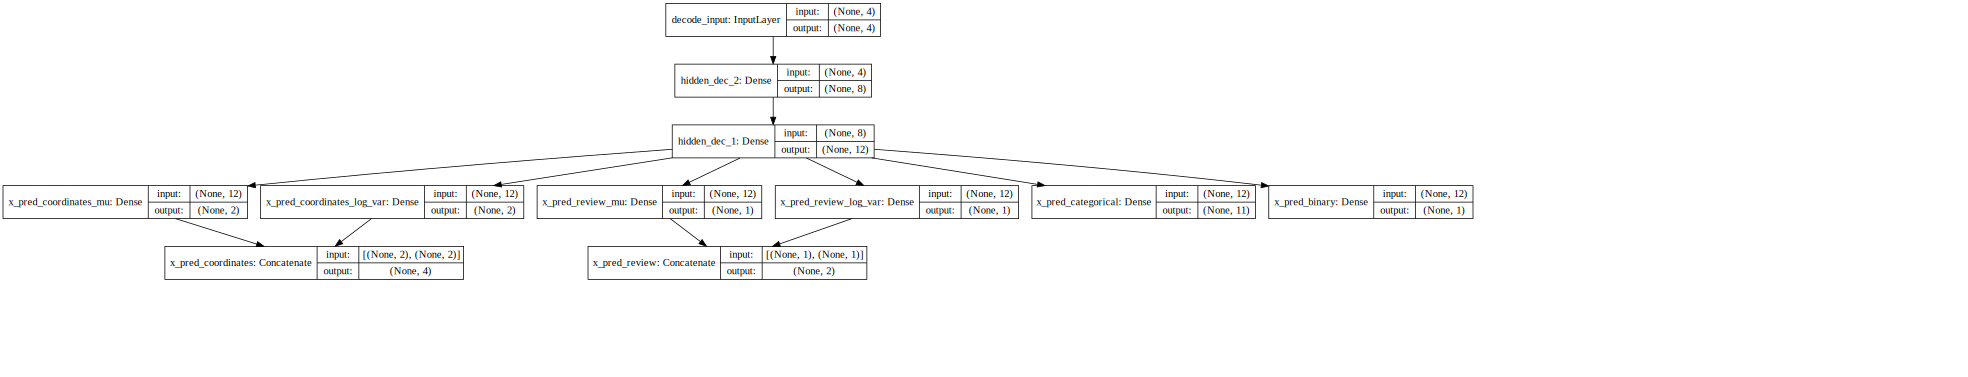

In [16]:
SVG(model_to_dot(decoder, show_shapes=True)
    .create(prog='dot', format='svg'))

### Saving the Models and Metadata
#### Saving Models (Actually, only the decoder matter)

In [17]:
model_json = vae.to_json()
with open("./model/vae_full_model.json", "w") as json_file:
    json_file.write(model_json)
vae.save_weights("./model/vae_full_model.h5")
print("Saved model to disk")

encoder = Model(x, [z_mu, z_log_var])
model_json = encoder.to_json()
with open("./model/vae_encoder.json", "w") as json_file:
    json_file.write(model_json)
encoder.save_weights("./model/vae_encoder.h5")
print("Saved model to disk")

model_json = decoder.to_json()
with open("./model/vae_decoder.json", "w") as json_file:
    json_file.write(model_json)
decoder.save_weights("./model/vae_decoder.h5")
print("Saved model to disk")


Saved model to disk
Saved model to disk
Saved model to disk


#### Generating and Saving Metadata

In [18]:
vae_sample = train_dataset[np.random.choice(len(train_dataset), size=10000, replace=False)]
vae_sample_mu, vae_sample_log_var = encoder.predict(vae_sample, batch_size=batch_size)
np.save('./model/sample_mu.npy', vae_sample_mu)
np.save('./model/sample_log_var.npy', vae_sample_log_var)

### Generating some Samples for Testing
#### Functions for data generation

In [26]:
reverse_categorical_map = {0:0, 1:0.5, 2:1, 3:1.5, 4:2, 5:2.5, 6:3, 7:3.5, 8:4, 9:4.5, 10:5}
def sample(model, input_mu, input_log_var, samples_per_z=1):
    multiplied_input_mu = np.repeat(input_mu, samples_per_z, axis=0)
    multiplied_input_log_var = np.repeat(input_log_var, samples_per_z, axis=0)
    eps = np.random.normal(size=(multiplied_input_mu.shape[0], latent_dim))
    z = reparameterize(multiplied_input_mu, multiplied_input_log_var, eps)
    predictions = model.predict(z, batch_size = None, steps = 1)
    return reconstruct(predictions)
    
def reconstruct(predictions):
    coordinates, review, categorical, binary = predictions
    mu, log_var = np.split(coordinates, indices_or_sections = 2,axis = 1)
    eps = np.random.normal(size=mu.shape)
    coordinates_data = reparameterize(mu, log_var, eps)
    print(coordinates_data)
    for i, c in enumerate(coordinates_data):
        if c[0] > 1.0:
            coordinates_data[i][0]=1.0
        if c[0] < 0.0:
            coordinates_data[i][0]=0.0
        if c[1] > 1.0:
            coordinates_data[i][1]=1.0
        if c[1] < 0.0:
            coordinates_data[i][1]=0.0
        coordinates_data[i][0] = (coordinates_data[i][0]*360)-180
        coordinates_data[i][1] = (coordinates_data[i][1]*360)-180
    mu2, log_var2 = np.split(review, indices_or_sections = 2,axis = 1)
    eps2 = np.random.normal(size=mu2.shape)
    review_data = reparameterize(mu2, log_var2, eps2)
    for i, r in enumerate(review_data):
        if r[0] < 0:
            review_data[i][0] = 0
        review_data[i][0] = float(int(review_data[i][0]))
    categorical = np.apply_along_axis(lambda t : np.random.multinomial(1,t), -1, categorical)
    categorical = np.apply_along_axis(lambda t : np.argmax(t), -1, categorical)
    categorical = np.expand_dims(categorical, axis = -1)
    categorical_data = np.apply_along_axis(lambda t : float(reverse_categorical_map[t[0]]), -1, categorical)
    categorical_data = np.expand_dims(categorical_data, axis = -1)
    binary_data = np.apply_along_axis(lambda t: np.random.binomial(1, t), -1, binary)
#     coordinates, reviews = np.split(continuous_data, indices_or_sections=[2], axis = 1)
    return np.concatenate([coordinates_data, categorical_data, review_data, binary_data], axis = 1)
    

def reparameterize(input_mu, input_log_var, eps):
    sigma = np.exp(0.5*input_log_var)
    return eps*sigma + input_mu

### Generating Samples
Make use of the funciton sample to generate samples with our model. U need to supply an array of mu and their respective log var in a separate array to do that. 

In [27]:
vae_samples = sample(decoder, vae_sample_mu, vae_sample_log_var)

# Saving the samples in a separate file
file_name = './samples/vae_3_sample_' + str(len(vae_samples)) + '.csv'
np.savetxt(file_name, vae_samples, delimiter = ',', header='latitude,longitude,stars,review_count,is_open')

[[0.62671493 0.29857437]
 [0.59624077 0.18579363]
 [0.62353369 0.28608704]
 ...
 [0.59723529 0.18847103]
 [0.64680217 0.50363678]
 [0.5973617  0.1845022 ]]


In [28]:
vae_samples[1:10]

array([[  34.6466784 , -113.11429171,    4.5       ,    4.        ,
           0.        ],
       [  44.47212863,  -77.00866647,    2.5       ,    7.        ,
           1.        ],
       [  40.67123489,  -80.58512095,    4.        ,    0.        ,
           1.        ],
       [  36.96850839, -110.17529572,    4.        ,   59.        ,
           1.        ],
       [  41.7360412 ,  -82.52277987,    4.        ,    0.        ,
           1.        ],
       [  41.7964105 ,  -78.62447006,    3.5       ,   19.        ,
           1.        ],
       [  46.2417926 ,  -76.93917101,    4.        ,    0.        ,
           1.        ],
       [  34.44739808, -113.25305354,    4.        ,   13.        ,
           1.        ],
       [  46.01539315,  -77.00811228,    5.        ,   44.        ,
           1.        ]])